# Reaction-Diffusion ;  the Gray-Scott Model

## Introduction théorique

#### The Gray-Scott Model
Le modèle de Gray-Scott permet de se représenter le comportement de deux espèces chimiques pouvant réagir entre elles selon une réaction donnée en fonction du temps.


Ce modèle est décrit par les deux équations différentielles suivantes, données dans l'énoncé:

$$\frac{\partial u}{\partial t}=D_u\nabla^2u-uv^2+F(1-u)$$
$$\frac{\partial v}{\partial t}=D_v\nabla^2v+uv^2-(F+k)v$$

Où $Du$ et $Dv$ sont respectivement les taux de diffusion des espèces $U$ et $V$ et $F$ et $k$ sont des constantes choisies arbitrairement. 

Ici, les variables $u$ et $v$ sont les concentrations spatiales des espèces $U$ et $V$. Ce modèle se base sur trois hypothèses : 

- les espèces $U$ et $V$ se diffusent dans l'espace suivant leur propre rythme

- le taux d'apport d'espèces $U$ dans le système reste constant

- Les espèces $U$ et $V$, lorsqu'elles se rencontrent  font la réaction $2V+U\rightarrow 3V $

- Les espèces $V$ sont "tuées" selon un taux constant.

En se penchant un peu plus sur les équations données et sans trop approfondir les détails, nous voyons que le premier terme du membre de droite de chaque équation représente la diffusion des particules. Le deuxième terme lui représente le fait que les particules intéragissent entre elles et enfin le dernier terme représente l'apport/destruction des espèces $U$/$V$.

#### Dicrétisation de l'équation
La première étape est donc de discrétiser ces équations pour les rendre utilisables dans le cadre d'une analyse numérique. L'énoncé demande de les discrétiser selon la méthode "forward-time central-space", ce qui donne directement

$\frac{u^{n+1}_{i,j}-u^{n}_{i,j}}{\Delta t}=D_u(\frac{u^{n}_{i+1,j}-2u^{n}_{i,j}+u^{n}_{i-1,j}}{\Delta x^2}+\frac{u^{n}_{i,j+1}-2u^{n}_{i,j}+u^{n}_{i,j-1}}{\Delta y^2})-u^{n}_{i,j}(v^{n}_{i,j})^2+F(1-u^{n}_{i,j})
\\
\frac{v^{n+1}_{i,j}-v^{n}_{i,j}}{\Delta t}=D_v(\frac{v^{n}_{i+1,j}-2v^{n+1}_{i,j}+v^{n}_{i-1,j}}{\Delta x^2}+\frac{v^{n}_{i,j+1}-2v^{n}_{i,j}+v^{n}_{i,j-1}}{\Delta y^2})+u^{n}_{i,j}(v^{n}_{i,j})^2-(F+k)v^{n}_{i,j}$

Pour nous clarifier les idées, mettons les termes connus a droite et le terme recherché à gauche.

$u^{n+1}_{i,j}=u^{n}_{i,j}+D_u\left(\frac{\Delta t}{\Delta x^2}(u^{n}_{i+1,j}-2u^{n}_{i,j}+u^{n}_{i-1,j})+\frac{\Delta t}{\Delta y^2}(u^{n}_{i,j+1}-2u^{n}_{i,j}+u^{n}_{i,j-1})\right)+\Delta t\left(-u^{n}_{i,j}(v^{n}_{i,j})^2+F(1-u^{n}_{i,j})\right)
\\
v^{n+1}_{i,j}=v^{n}_{i,j}+D_v\left(\frac{\Delta t}{\Delta x^2}(v^{n}_{i+1,j}-2v^{n}_{i,j}+v^{n}_{i-1,j})+\frac{\Delta t}{\Delta y^2}(v^{n}_{i,j+1}-2v^{n}_{i,j}+v^{n}_{i,j-1})\right)+\Delta t\left(u^{n}_{i,j}(v^{n}_{i,j})^2-(F+k)v^{n}_{i,j}\right)$

Donc cette discrétisaton nous permettra de calculer $u$ et $v$ après un certain pas temporel en sachant leurs valeurs au pas précédent. Il s'agit d'une discrétisation "explicite" puisqu'elle n'utilise que des valeurs déjà calculées au préalable afin d'en calculer de nouvelles.

#### Conditons aux bords
L'énoncé demande de poser à tout instant des conditions de Neuwmann nulles sur tous les bords du domaine pour $u$ et $v$. Pour ce faire, comme présenté dans les notebooks, nous allons utiliser la "finite-difference discretization" se présentant comme suit:

$$\left.\frac{\partial u}{\partial x}\right|_{x=\text{bord}}=\left.\frac{\partial u}{\partial y}\right|_{y=\text{bord}}=\left.\frac{\partial v}{\partial x}\right|_{x=\text{bord}}=\left.\frac{\partial v}{\partial y}\right|_{y=\text{bord}}=0$$

Nous allons développer comme exemple la première de ces conditions (le raisonnement étant appliquable pour les trois autres). La "finite-difference discretization" se présentera donc ainsi

$$\left.\frac{\partial u}{\partial x}\right|_{x=\text{bord}}=\frac{u^n_{\text{bord},j}-u^n_{\text{bord}-1,j}}{\Delta x}=0 \Leftrightarrow u^n_{\text{bord},j}=u^n_{\text{bord}-1,j}$$

Toutes ces conditions seront directement implémentées dans l'algorithme, à chaque itération.





## Programme

Importons tout d'abord les packages habituels

In [69]:
import numpy
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams, cm
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
import time

Ensuite nous implémentons les conditions initiales livrées par l'énoncé

In [70]:
n = 192 # nombre de points dans une dimension de l'espace discrétisé
Du, Dv, F, k = 0.00016, 0.00008, 0.035, 0.065 # Bacteria 1 (énoncé) 
dh = 5./(n-1) # valeur identique de dx et de dy, les pas spatiaux dans les 2 dimensions
T = 8000 # temps total d'observation
dt = .9 * dh**2 / (4*max(Du,Dv)) # pas temporel
nt = int(T/dt) # nombre de pas temporels pour arriver a T en s'assurant qu'il s'agisse d'un entier

Comme proposé, nous importons dans notre programme les conditions initiales pour $u$ et $v$, créées selon un processus aléatoire. Nous mettons dans le tableau $U$ les valeurs dicrétisées de $u$, et nous procédons de la même manière pour les valeurs discrétisées de $v$, implémentées dans le tableau $V$.

In [71]:
uvinitial = numpy.load('uvinitial.npz')
U = uvinitial['U']
V = uvinitial['V']

Ci-joint une figure représentant ces conditions initiales dans l'espace dicrétisé ($u$ représenté à gauche et $v$ à droite)

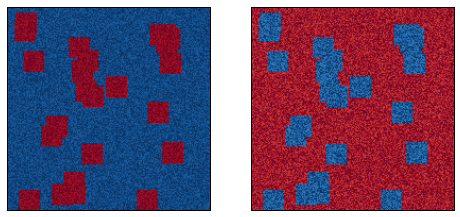

In [72]:
fig = pyplot.figure(figsize=(8,5))
pyplot.subplot(121)
pyplot.imshow(U, cmap = cm.RdBu)
pyplot.xticks([]), pyplot.yticks([]);
pyplot.subplot(122)
pyplot.imshow(V, cmap = cm.RdBu)
pyplot.xticks([]), pyplot.yticks([]);

Enfin nous créons le coeur du programme : nous allons créer une fonction itérant $nt$ fois le calcul des $u^{n+1}_{i,j}$ et $v^{n+1}_{i,j}$, en respectant à chaque étape les conditions de Neumann.

In [58]:
def ftcs(U, V, nt, Du, Dv, dt, dh, F, k):
   
    for n in range(nt):
        Un = U.copy()
        Vn = V.copy()
        U[1:-1,1:-1] = Un[1:-1,1:-1] + Du *\
            (dt/(dh**2) * (Un[2:,1:-1] - 2*Un[1:-1,1:-1] + Un[:-2,1:-1]) +\
             dt/(dh**2) * (Un[1:-1,2:] - 2*Un[1:-1,1:-1] + Un[1:-1,:-2]))+\
             dt*(-Un[1:-1,1:-1]*(Vn[1:-1,1:-1]**2)+F*(1-Un[1:-1,1:-1])) 
        V[1:-1,1:-1] = Vn[1:-1,1:-1] + Dv *\
            (dt/(dh**2) * (Vn[2:,1:-1] - 2*Vn[1:-1,1:-1] + Vn[:-2,1:-1]) +\
             dt/(dh**2) * (Vn[1:-1,2:] - 2*Vn[1:-1,1:-1] + Vn[1:-1,:-2]))+\
            dt*(Un[1:-1,1:-1]*(Vn[1:-1,1:-1]**2)-(F+k)*Vn[1:-1,1:-1])
        # Enforce Neumann BCs
        U[-1,:] = U[-2,:]
        V[-1,:] = V[-2,:]
        U[:,-1] = U[:,-2]
        V[:,-1] = V[:,-2]
        U[0,:] = U[1,:]
        V[0,:] = V[1,:]
        U[:,0] = U[:,1]
        V[:,0] = V[:,1]
        
    return U, V

Maintenant faisons appel à cette fonction. elle nous donnera donc les tableaux $U$ et $V$ après les $nt$ itérations.

In [73]:
ftcs(U, V, nt, Du, Dv, dt, dh, F, k)

(array([[ 0.95240393,  0.95240393,  0.94891616, ...,  0.98932024,
          0.99061544,  0.99061544],
        [ 0.95240393,  0.95240393,  0.94891616, ...,  0.98932024,
          0.99061544,  0.99061544],
        [ 0.94872314,  0.94872314,  0.94454883, ...,  0.9890645 ,
          0.99042336,  0.99042336],
        ..., 
        [ 0.95622777,  0.95622777,  0.95239656, ...,  0.99488881,
          0.99538486,  0.99538486],
        [ 0.95910378,  0.95910378,  0.95585264, ...,  0.99509444,
          0.99557349,  0.99557349],
        [ 0.95910378,  0.95910378,  0.95585264, ...,  0.99509444,
          0.99557349,  0.99557349]]),
 array([[  4.65087333e-04,   4.65087333e-04,   6.62203073e-04, ...,
           2.39368299e-05,   1.39084142e-05,   1.39084142e-05],
        [  4.65087333e-04,   4.65087333e-04,   6.62203073e-04, ...,
           2.39368299e-05,   1.39084142e-05,   1.39084142e-05],
        [  6.66030335e-04,   6.66030335e-04,   9.85165548e-04, ...,
           2.87133883e-05,   1.63095284e

In [57]:
start_time = time.time()
ftcs(U, V, nt, Du, Dv, dt, dh, F, k)
print("La fonction met %s secondes à s'effectuer." % (time.time() - start_time))

La fonction met 16.554214477539062 secondes à s'effectuer.


Le résultat affiché varie légèrement entre 17 et 20 secondes.

On constate que la fonction que nous avons créée prend beaucoup de temps à s'effectuer, puisqu'elle réalise énormément d'opérations (un grand nombre de pas et surtout un grand nombre de tableaux à calculer à chaque fois). Nous allons donc factoriser nos discrétisations au maximum afin d'avoir à calculer moins de tableaux.

In [74]:
# VAS-Y SACHA CORRIGE-MOI CA !!!!!!!
# Ce serait bien d'écrire en latex les formules factorisées juste au-dessus de cette cellule 

def ftcs_short(U, V, nt, Du, Dv, dt, dh, F, k):
    
    for n in range(nt):
        Un = U.copy()
        Vn = V.copy()
        
        U[1:-1,1:-1] = Un[1:-1,1:-1] * (1 - 4*Du*dt/(dh**2) - dt*((Vn[1:-1,1:-1]**2) - F)) +\
             Du*dt/(dh**2) * (Un[2:,1:-1] + Un[:2,1:-1] + Un[1:-1,2:] + Un[1:-1,:-2]) + F*dt
        V[1:-1,1:-1] = Vn[1:-1,1:-1] * (1 - 4*Dv*dt/(dh**2) + dt*((Un[1:-1,1:-1]*Vn[1:-1,1:-1]) - k)) +\
             Dv*dt/(dh**2) * (Vn[2:,1:-1] + Vn[:2,1:-1] + Vn[1:-1,2:] + Vn[1:-1,:-2]) - F*dt
        
        # Enforce Neumann BCs
        U[-1,:] = U[-2,:]
        V[-1,:] = V[-2,:]
        U[:,-1] = U[:,-2]
        V[:,-1] = V[:,-2]
        U[0,:] = U[1,:]
        V[0,:] = V[1,:]
        U[:,0] = U[:,1]
        V[:,0] = V[:,1]
        
    return U, V

In [75]:
ftcs_short(U, V, nt, Du, Dv, dt, dh, F, k)

ValueError: operands could not be broadcast together with shapes (190,190) (2,190) 



La situation après 8000 pas de nt peut être représentée visuellement sur les figures qui suivent. 

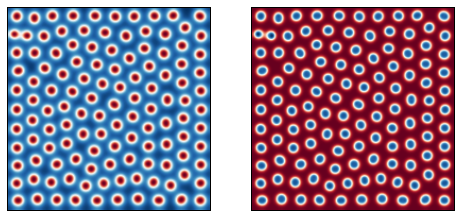

In [49]:
fig = pyplot.figure(figsize=(8,5))
pyplot.subplot(121)
pyplot.imshow(U, cmap = cm.RdBu)
pyplot.xticks([]), pyplot.yticks([]);
pyplot.subplot(122)
pyplot.imshow(V, cmap = cm.RdBu)
pyplot.xticks([]), pyplot.yticks([]);


En guise de vérification, l'énoncé nous demande de renvoyer les concentrations de l'espèce U aux points d'abscisse 100 et dont l'ordonnée vaut 40n + 1, nous donnant cinq nombres puisque les valeurs n = 0, 1, 2, 3, 4 correspondent à une ordonnée plus petite que 192.
(Attention, les mots "absicsse" et "ordonnée" sont assez mal choisis ici. On veut simplement parler de la place des points dans la 1ère et dans la 2ème colonne du tableau.)

In [76]:
U[100,::40]

array([ 0.92469521,  0.85013834,  0.66815621,  0.90196481,  0.9039502 ])

Ce qui est correct.